# Laboratory work 2. Model Sensitivity and Uncertainty Analysis
- Perform a sensitivity analysis for a demographic model with respect to a set of parameters: fertility rate, boys/girls ratio, «survival» rate for different age groups (not all can be taken). Model output: number of inhabitants for a given year. Test on the final forecast values ​​for 10, 20, 50, 100 years.
- Define ranges of model parameter values ​​from data for previous periods (1950-2000)
- Based on all ranges of parameter values, perform an uncertainty analysis in the form of a graph with prediction intervals of the results (calculated based on various scenarios, see slide 7). The values ​​between the boundaries can be considered evenly distributed.

In [1]:
import random
import math

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
!pip install SALib
from SALib.sample import saltelli
from SALib.analyze import sobol

!pip install openpyxl
import openpyxl
from IPython.display import clear_output

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.figsize"] = (10, 6)


import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 28.6 MB/s eta 0:00:00


## We are going to poerform Model Sensitivity and Uncertainty Analysis on South Korea data
![img](https://img.freepik.com/free-vector/flat-design-south-korea-map-design_23-2149598673.jpg?w=2000)

In [2]:
data = pd.read_excel("age_data_2005.xlsx", sheet_name="both; 1950-2005, estimates")
data = data[data["Region"]=="Republic of Korea"].replace("-", np.nan).reset_index(drop=True)
GROUPS = [f"{k*5} - {(k+1)*5-1}" for k in range(20)] + ["100+"]
SR = [f"SR: {k*5} - {(k+1)*5-1}" for k in range(1,20)] + ["SR: 100+"]
YEARS = np.sort(data["Year"].unique())
data.loc[
    data["Year"].isin(YEARS[1:]),
    SR
] = data[
    data["Year"].isin(YEARS[1:])
][GROUPS[1:]].values / data[
    data["Year"].isin(YEARS[:-1])
][GROUPS[:-1]].values

In [3]:
dataM = pd.read_excel("age_data_2005.xlsx", sheet_name="m; 1950-2005, estimates")
dataM = dataM[dataM["Region"]=="Republic of Korea"].replace("-", np.nan).reset_index(
    drop=True
)
dataM.loc[dataM["Year"].isin(YEARS[1:]), SR] = dataM[
    dataM["Year"].isin(YEARS[1:])
][GROUPS[1:]].values / dataM[dataM["Year"].isin(YEARS[:-1])][GROUPS[:-1]].values

In [4]:
dataF = pd.read_excel("age_data_2005.xlsx", sheet_name="f; 1950-2005, estimates")
dataF = dataF[dataF["Region"]=="Republic of Korea"].replace("-", np.nan).reset_index(
    drop=True
)
dataF.loc[dataF["Year"].isin(YEARS[1:]), SR] = dataF[
    dataF["Year"].isin(YEARS[1:])
][GROUPS[1:]].values / dataF[dataF["Year"].isin(YEARS[:-1])][GROUPS[:-1]].values

In [5]:
n1, n2 = 4, 8 # groups able to birth
dataF["FR"] = dataF[GROUPS[0]] / dataF[GROUPS[n1:n2]].sum(axis=1)

## Perform a sensitivity analysis for a demographic model with respect to a set of parameters:

**Fertility rate**
$$ FR = \frac{P_{1,0}^F}{\sum_{i={n_1}}^{n_2} P_{1,i}^F} - fertility\ rate\\ $$

**Boys/girls ratio**

$$ BG = \frac{P_{1,0}^M}{P_{1,0}^F} - boys/girs\ ratio\\ $$

**"survivial" rates**
$ SR^F = \frac{P_{1,1:n+1}^F}{P_{0,0:n}^F} - females\ survival\ rate\ profile\\ $
$ SR^M = \frac{P_{1,1:n+1}^M}{P_{0,0:n}^M} - males\ survival\ rate\ profile\\ $

### Fertility rate calculation

In [6]:
FRmin, FRmax = dataF["FR"].min(), dataF["FR"].max()
print(f"Fertility rate min: {FRmin}\nFertility rate max: {FRmax}")

Fertility rate min: 0.15046867355300844
Fertility rate max: 0.6088739240231352


### Boys/girls ratio calculation

In [7]:
BGs = dataM[GROUPS[0]] / dataF[GROUPS[0]]
BGmin, BGmax = BGs.min(), BGs.max()
print(f"Boys/Girls min: {BGmin}\nBoys/Girls max: {BGmax}")

Boys/Girls min: 1.0342506254264272
Boys/Girls max: 1.1297679372079235


### «Survival» rate calculation

In [8]:
SRmin, SRmax = [], []
for group in GROUPS[1:]:
    SRmin.append(min(dataM[f"SR: {group}"].min(), dataF[f"SR: {group}"].min()))
    SRmax.append(max(dataM[f"SR: {group}"].max(), dataF[f"SR: {group}"].max()))
SRmin = dict(zip(GROUPS[1:], SRmin))
SRmax = dict(zip(GROUPS[1:], SRmax))

# Sensitivity analysis

In [9]:
def Model_sens(
        init_profile_F,
        init_profile_M, 
        SR,
        FR,
        BG,
        agegroup,
        init_year=2005,
        kmax=1):
    sratesF = SR
    sratesM = SR
    n1, n2 = 4, 8
    profile1M = init_profile_M
    profile1F = init_profile_F
    year = init_year
    for k in range(kmax):
        profile2F = np.zeros_like(profile1F) 
        profile2F[1:] = sratesF*profile1F[:-1]
        profile2F[0] = FR*(profile2F[n1:n2]).sum()
        profile1F = profile2F
        
        profile2M = np.zeros_like(profile1M)       
        profile2M[1:] = sratesM*profile1M[:-1]
        profile2M[0] = profile2F[0] * BG
        profile1M = profile2M
        
        year += 5
    profile = profile2F + profile2M
    return profile[GROUPS.index(agegroup)]

In [10]:
def Eval_sens(
        params_sets,
        model, 
        leave=False,
        kwargs={}):
    
    results = []
    for params_set in tqdm(params_sets, total=len(params_sets), leave=leave):
        kwargs["SR"] = params_set[2:]
        kwargs["FR"] = params_set[0]
        kwargs["BG"] = params_set[1]
        results.append(model(**kwargs))
    return np.array(results)

In [11]:
def analyse_sens(
        agegroup, 
        problem, 
        kwargs, 
        Model_sens, 
        Eval, 
        nvals=1000, 
        max_time_steps=9, 
        leave=False):
    results = []
    kwargs["agegroup"] = agegroup
    param_values = saltelli.sample(problem, nvals)
    Years = [kwargs["init_year"]]
    for kmax in tqdm(range(1, max_time_steps+1), leave=leave):  
        kwargs["kmax"] = kmax
        Years.append(Years[-1] + 5)
        Y = Eval_sens(param_values, Model_sens, kwargs=kwargs)
        Si = sobol.analyze(problem, Y, print_to_console=False)
        results.append(Si["S1"])
    results = np.array(results)
    results = dict(zip(problem["names"], results.T))
    results["year"] = Years[1:]
    return results

In [12]:
def full_analysis_sens(
        problem, 
        kwargs, 
        Model_sens, 
        Eval_sens, 
        nvals=1000, 
        max_time_steps=9):
    results = pd.DataFrame()
    results["year"] = [kwargs["init_year"] + k*5 for k in range(1, max_time_steps+1)]
    kwargs["kmax"] = max_time_steps
    for agegroup in tqdm(GROUPS[1:GROUPS.index("45 - 49") + 1]):
        res = analyse_sens(agegroup, problem, kwargs, Model_sens, Eval_sens, nvals=nvals, max_time_steps=max_time_steps)
        for name in problem["names"]:
            results[f"{name}_{agegroup}"] = res[name]
    return results

In [13]:
n1, n2 = 4, 8
SRATES_F = dataF[dataF["Year"]==2005][SR].mean(axis=0).values
SRATES_M = dataM[dataM["Year"]==2005][SR].mean(axis=0).values
init_profile_F = dataF[dataF["Year"]==2005][GROUPS].values.reshape(-1)
init_profile_M = dataM[dataM["Year"]==2005][GROUPS].values.reshape(-1)
BG_ratio = (dataM[dataM["Year"]==2005][GROUPS[0]] / dataF[
    dataF["Year"]==2005
][GROUPS[0]]).values[0]
FR_coef = dataF["FR"][11]

In [14]:
names = ["FR", "BG"] + [f"SR({k})" for k in SRmin.keys()]
problem = {
    "num_vars": len(names),
    "names": names,
    "bounds": [[FRmin, FRmax], [BGmin, BGmax]]+list(zip(SRmin.values(), SRmax.values()))
}
kwargs = {
    "init_profile_F": init_profile_F,
    "init_profile_M": init_profile_M, 
    "init_year": 2005
}
S1 = full_analysis_sens(problem, kwargs, Model_sens, Eval_sens, nvals=1000, max_time_steps=9)

In [15]:
S1.to_excel("S1.xlsx")
S1 = pd.read_excel("S1.xlsx")

In [16]:
for group in GROUPS:
    new = S1[[col for col in S1.columns if ("SR" in col) and (f"_{group}" in col)]].sum(axis=1)
    S1 = S1.drop([col for col in S1.columns if ("SR" in col) and (f"_{group}" in col)], axis=1)
    S1[f"SR_{group}"] = new

In [17]:
S1.head()

,Unnamed: 0,year,FR_5 - 9,BG_5 - 9,FR_10 - 14,BG_10 - 14,FR_15 - 19,BG_15 - 19,FR_20 - 24,BG_20 - 24,...,SR_55 - 59,SR_60 - 64,SR_65 - 69,SR_70 - 74,SR_75 - 79,SR_80 - 84,SR_85 - 89,SR_90 - 94,SR_95 - 99,SR_100+
0,0,2010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2015,0.996623,0.001062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2020,0.988120,0.001049,0.983247,0.001073,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2025,0.975691,0.001037,0.974941,0.001055,0.980363,0.001060,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2030,0.953138,0.001023,0.957530,0.001037,0.970840,0.001031,0.943631,0.001052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
def plotAgeGroupSensevity(params, df):
    groups = [col.replace("FR_", "") for col in df.columns if "FR" in col]
    K = len(groups)
    for rowNum, group in enumerate(groups):
        fig = go.Figure()
        for i, param in enumerate(params):
            fig.add_trace(
                go.Scatter(
                    x=df["year"], 
                    y=df[f"{param}_{group}"],
                    name=param,
                ),
            )
        fig.update_layout(title_text=f"Age {group}")
        fig.update_xaxes(title_text="Year")
        fig.update_yaxes(title_text="Sensitivity")
        fig.show()

## Sensitivity analysis of South Korea demographic

In [19]:
plotAgeGroupSensevity(["FR", "BG", "SR"], S1)

## Uncertainty analysis

In [20]:
def Model_unce(init_profile_F, init_profile_M,
          SR, FR, BG, agegroup=None, init_year=2005, kmax=1):
    sratesF = SR
    sratesM = SR
    n1, n2 = 4, 8
    
    profiles = []
    profile1M = init_profile_M
    profile1F = init_profile_F
    for k in range(kmax):
        profile2F = np.zeros_like(profile1F) 
        profile2F[1:] = sratesF*profile1F[:-1]
        profile2F[0] = FR*(profile2F[n1:n2]).sum()
        profile1F = profile2F
        
        profile2M = np.zeros_like(profile1M)       
        profile2M[1:] = sratesM*profile1M[:-1]
        profile2M[0] = profile2F[0] * BG
        profile1M = profile2M    
        profiles.append(profile2F + profile2M)
    return np.array(profiles)[:, GROUPS.index(agegroup)]

In [21]:
def analyse_unce(agegroup, problem, kwargs, model, nvals=1000, max_time_steps=9, leave=False):
    Y = []    
    param_values = saltelli.sample(problem, nvals)
    kwargs["agegroup"] = agegroup
    kwargs["kmax"] = max_time_steps
    for v in tqdm(param_values, total=len(param_values), leave=leave):
        kwargs["FR"] = v[0]
        kwargs["BG"] = v[1]
        kwargs["SR"] = v[2:]
        Y.append(model(**kwargs))
    return np.array(Y)

In [22]:
def full_analysis_unce(agegroups, problem, kwargs, model, nvals=1000, max_time_steps=9, leave=True):
    results = {"datasets": [], "agegroups": agegroups, 
               "year": [kwargs["init_year"] + (k+1)*5 for k in range(max_time_steps)]}
    kwargs["kmax"] = max_time_steps
    for agegroup in tqdm(agegroups, leave=leave):
        Y = analyse_unce(agegroup, problem, kwargs, model, nvals=nvals, max_time_steps=max_time_steps)
        results["datasets"].append(Y)
    results["datasets"] = np.array(results["datasets"])
    return results

In [23]:
def compute_percentiles(dictionary, intervals):
    total = np.expand_dims(dictionary["datasets"].mean(axis=0), axis=0)
    dictionary["datasets"] = np.concatenate([dictionary["datasets"], total], axis=0)
    dictionary["agegroups"].append("total")
    dictionary["percentiles"] = {}
    for i in intervals:
        dictionary["percentiles"][f"{i}"] = [np.percentile(data, [50-i/2,50+i/2], axis=0) for data in dictionary["datasets"]]   
    return dictionary    

In [24]:
names = ["FR", "BG"] + [f"SR({k})" for k in SRmin.keys()]
problem = {
    "num_vars": len(names),
    "names": names,
    "bounds": [[FRmin, FRmax], [BGmin, BGmax]] + list(zip(SRmin.values(), SRmax.values()))

}

kwargs = {
    "init_profile_F": init_profile_F,
    "init_profile_M": init_profile_M,
    "init_year": 2005
}

agegroups = GROUPS[1:GROUPS.index("40 - 44")+1]

output = full_analysis_unce(agegroups, problem, kwargs, Model_unce, nvals=1000, max_time_steps=20)

In [25]:
output2 = compute_percentiles(output, [50, 70, 90])

In [114]:
def plotAgeGroupUncertaintyMPL(
        output,
        both_df,
        both_pred_df,
        num_lines,
        gigachads=[0.8, 0.5, 0.3]
    ):
    colors = px.colors.qualitative.Plotly
    K = len(num_lines)
    fig, axs = plt.subplots(K, figsize=(20, 8*K))  
    for it, ids in enumerate(num_lines):
        try:
            ax = axs[it]
        except:
            ax = axs
        
        for i, k in enumerate(ids):
            color = colors[it]
            group = output["agegroups"][k]
            

            mean_ = output["datasets"][k,:,:].mean(axis=-2)
            ax.plot(output["year"][:9], mean_[:9], linewidth=5, label=f"{group}", color=color)

            ax.plot(output["year"][:9], both_cleaned_2010_2050_df[group], linewidth=5, label=f"Exel True data", color="#bcbd22", alpha=0.85)
            ax.plot(output["year"][:9], both_pred_2010_2050_df[group], linewidth=5, label=f"Pred from Lab 1", linestyle="--", color="#7f7f7f", alpha=0.75)

            for j, perc in enumerate(list(output["percentiles"].keys())):
                bottom = output["percentiles"][perc][k][0]
                top = output["percentiles"][perc][k][1]
                ax.fill_between(output["year"][:9], bottom[:9], top[:9], color=color, alpha=gigachads[j],
                               label=f"{group}: {perc}% interval")
        ax.tick_params(axis="x", labelsize=18) 
        ax.tick_params(axis="y", labelsize=18) 
        ax.set_xlabel("Year", fontsize=18)
        ax.set_ylabel("Population", fontsize=18)
        ax.grid()
        ax.legend(fontsize=18)
    
    plt.show()

In [84]:
both_cleaned_2010_2050_df = pd.read_csv(
    "/data/notebook_files/both_cleaned_2010_2050_df.csv", 
)

In [85]:
both_pred_2010_2050_df = pd.read_csv(
    "/data/notebook_files/both_cleaned_2010_2050_df.csv", 
)

both_pred_2010_2050_df.head(1)

,Index,Variant,Region,Notes,Country code,Year,0 - 4,5 - 9,10 - 14,15 - 19,...,SR: 55 - 59,SR: 60 - 64,SR: 65 - 69,SR: 70 - 74,SR: 75 - 79,SR: 80 - 84,SR: 85 - 89,SR: 90 - 94,SR: 95 - 99,FR
0,77,Medium,Republic of Korea,NaN,410,2010,2223.961,2409.136,3062.623,3406.574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.149204


In [128]:
both_cleaned_2010_2050_df["total"] = both_cleaned_2010_2050_df[GROUPS[1:10]].mean(axis=1)
both_cleaned_2010_2050_df.head(1)

,Index,Variant,Region,Notes,Country code,Year,0 - 4,5 - 9,10 - 14,15 - 19,...,SR: 60 - 64,SR: 65 - 69,SR: 70 - 74,SR: 75 - 79,SR: 80 - 84,SR: 85 - 89,SR: 90 - 94,SR: 95 - 99,FR,total
0,77,Medium,Republic of Korea,NaN,410,2010,2223.961,2409.136,3062.623,3406.574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.149204,3547.380778


In [129]:
both_pred_2010_2050_df["total"] = both_pred_2010_2050_df[GROUPS[1:10]].mean(axis=1)
both_pred_2010_2050_df.head(1)

,Index,Variant,Region,Notes,Country code,Year,0 - 4,5 - 9,10 - 14,15 - 19,...,SR: 60 - 64,SR: 65 - 69,SR: 70 - 74,SR: 75 - 79,SR: 80 - 84,SR: 85 - 89,SR: 90 - 94,SR: 95 - 99,FR,total
0,77,Medium,Republic of Korea,NaN,410,2010,2223.961,2409.136,3062.623,3406.574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.149204,3547.380778


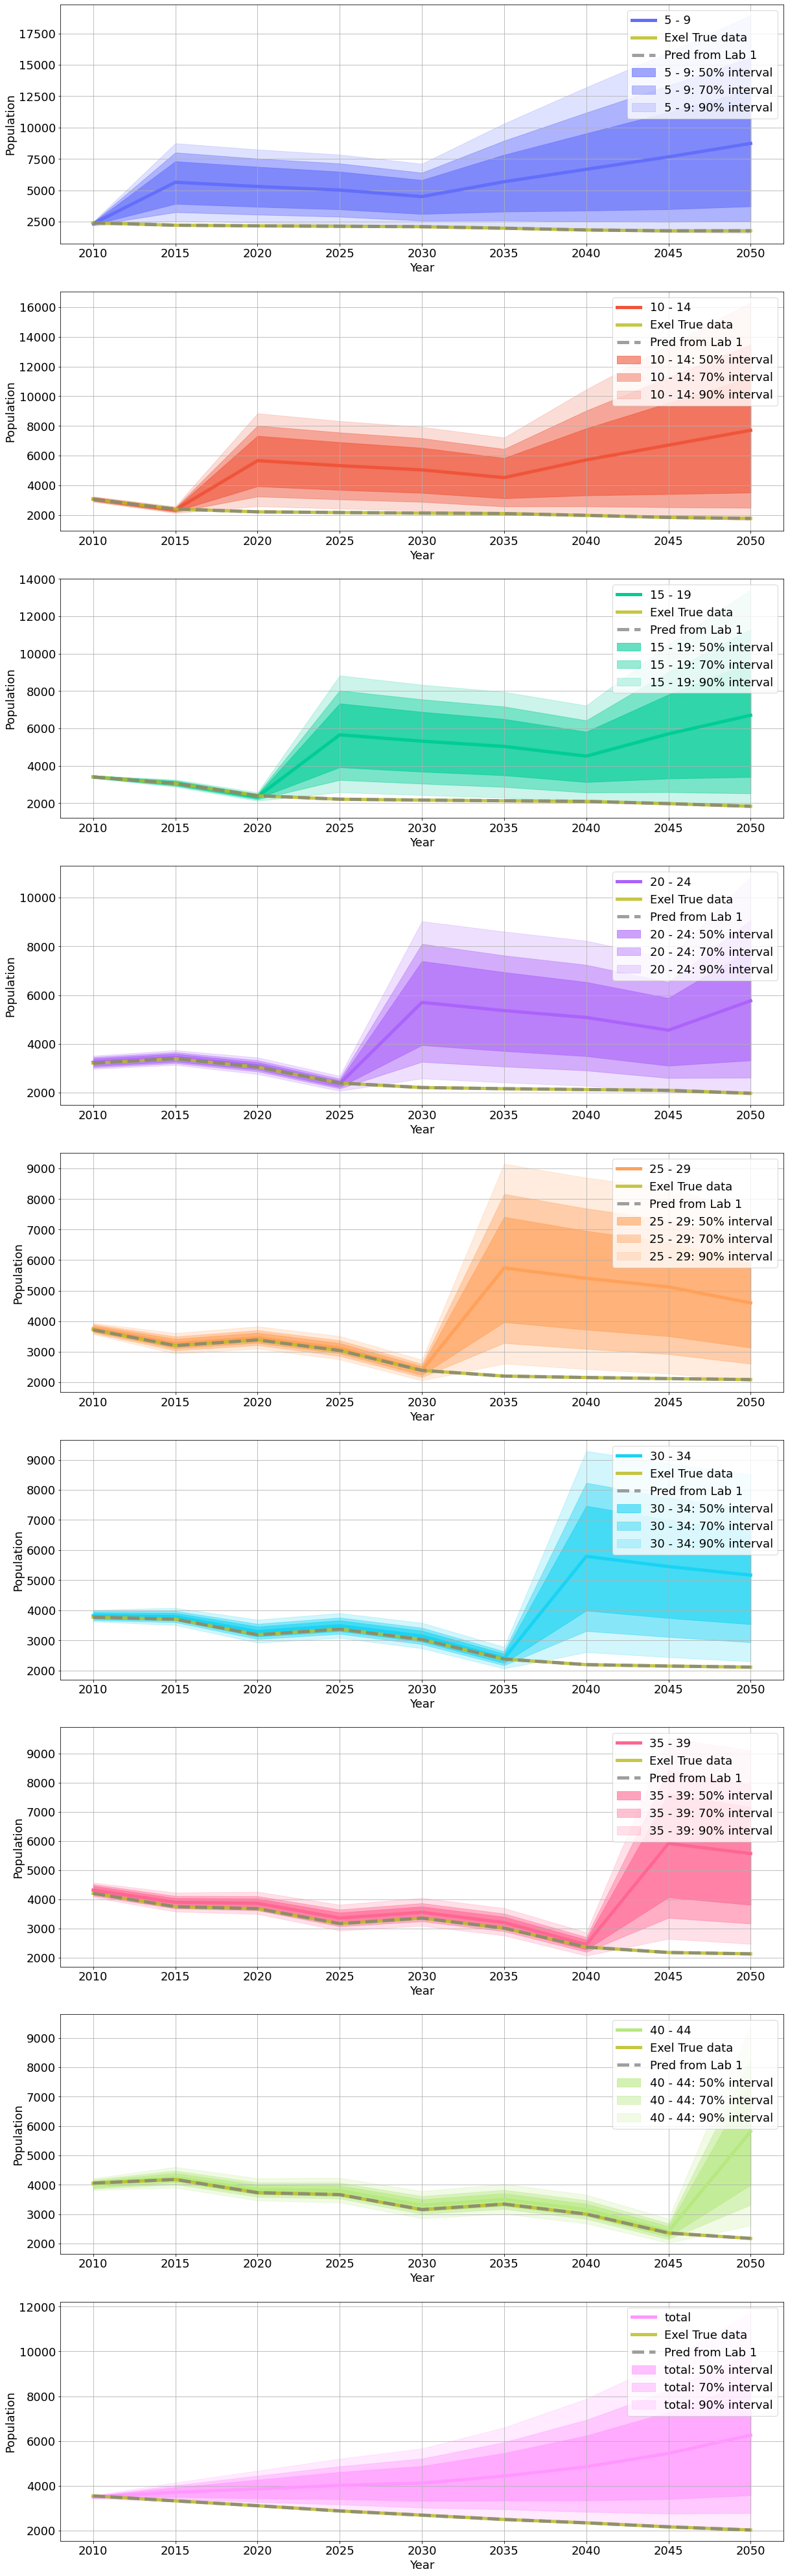

In [130]:
plotAgeGroupUncertaintyMPL(
    output2,
    both_cleaned_2010_2050_df,
    both_pred_2010_2050_df,
    [[k] for k in range(len(output["agegroups"]))], gigachads=[0.6, 0.4, 0.2])

In [28]:
pd.Series(output["year"])

0 2010
1 2015
2 2020
3 2025
4 2030
5 2035
6 2040
7 2045
8 2050
9 2055
10 2060
11 2065
12 2070
13 2075
14 2080
15 2085
16 2090
17 2095
18 2100
19 2105
dtype: int64

In [29]:
def plotAgeGroupUncertainty(output, num_lines, gigachads=[0.8, 0.5, 0.3]):
    K = len(num_lines)

    for it, ids in enumerate(num_lines):
        fig = go.Figure()
        for i, k in enumerate(ids):
            group = output["agegroups"][k]
            mean_ = output["datasets"][k,:,:].mean(axis=-2)
            for j, perc in enumerate(list(output["percentiles"].keys())):
                y_upper = pd.Series(output["percentiles"][perc][k][1])
                y_lower = pd.Series(output["percentiles"][perc][k][0])

                fig.add_trace(
                    go.Scatter(
                        x=pd.Series(output["year"]) + pd.Series(output["year"])[::-1],
                        y=y_upper, # upper, then lower reversed
                        fill='tonexty',
                        hoveron='points',
                        name=f"{perc}%",
                    )
                )
        fig.update_layout(title_text=f"Age {group}")
        fig.update_xaxes(title_text="Year")
        fig.update_yaxes(title_text="Population")
        fig.show()

In [30]:
plotAgeGroupUncertainty(output2, [[k] for k in range(len(output["agegroups"]))], gigachads=[0.6, 0.4, 0.2])